### Introduction

The objective of this challenge is to create machine learning models that use open-source emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

Approximately 497 unique locations were selected from multiple areas in Rwanda, with a distribution around farm lands, cities and power plants. The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and your task is to predict the **CO2 emissions data for 2022 through November**

Seven main features were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature (Sulphur Dioxide, Carbon Monoxide, etc) contain sub features such as column_number_density which is the vertical column density at ground level, calculated using the DOAS technique. You can read more about each feature in the below links, including how they are measured and variable definitions. You are given the values of these features in the test set and your goal to predict CO2 emissions using time information as well as these features.

- Sulphur Dioxide - COPERNICUS/S5P/NRTI/L3_SO2
- Carbon Monoxide - COPERNICUS/S5P/NRTI/L3_CO
- Nitrogen Dioxide - COPERNICUS/S5P/NRTI/L3_NO2
- Formaldehyde - COPERNICUS/S5P/NRTI/L3_HCHO
- UV Aerosol Index - COPERNICUS/S5P/NRTI/L3_AER_AI
- Ozone - COPERNICUS/S5P/NRTI/L3_O3
- Cloud - COPERNICUS/S5P/OFFL/L3_CLOUD
- Important: Please only use the data provided for this challenge as part of your modeling effort. Do not use any external data, including any data from Sentinel-5P not provided on this page.

### Import Data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [26]:
# Import train.csv from data folder
df = pd.read_csv('data/train.csv')
print(df.columns)

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [27]:
df.head(500)

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0    ID_-0.510_29.290_2019_00    -0.510     29.290  2019        0   
1    ID_-0.510_29.290_2019_01    -0.510     29.290  2019        1   
2    ID_-0.510_29.290_2019_02    -0.510     29.290  2019        2   
3    ID_-0.510_29.290_2019_03    -0.510     29.290  2019        3   
4    ID_-0.510_29.290_2019_04    -0.510     29.290  2019        4   
..                        ...       ...        ...   ...      ...   
495  ID_-0.569_30.031_2019_18    -0.569     30.031  2019       18   
496  ID_-0.569_30.031_2019_19    -0.569     30.031  2019       19   
497  ID_-0.569_30.031_2019_20    -0.569     30.031  2019       20   
498  ID_-0.569_30.031_2019_21    -0.569     30.031  2019       21   
499  ID_-0.569_30.031_2019_22    -0.569     30.031  2019       22   

     SulphurDioxide_SO2_column_number_density  \
0                                   -0.000108   
1                                    0.000021   
2                                    0.000514   
3                                         NaN   
4                                   -0.000079   
..                                        ...   
495                                  0.000014   
496                                 -0.000048   
497                                 -0.000211   
498                                  0.000107   
499                                  0.000236   

     SulphurDioxide_SO2_column_number_density_amf  \
0                                        0.603019   
1                                        0.728214   
2                                        0.748199   
3                                             NaN   
4                                        0.676296   
..                                            ...   
495                                      0.896807   
496                                      0.780635   
497                                      0.815767   
498                                      0.702677   
499                                      0.916479   

     SulphurDioxide_SO2_slant_column_number_density  \
0                                         -0.000065   
1                                          0.000014   
2                                          0.000385   
3                                               NaN   
4                                         -0.000048   
..                                              ...   
495                                        0.000010   
496                                       -0.000032   
497                                       -0.000171   
498                                        0.000074   
499                                        0.000217   

     SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                         0.255668                           -98.593887  ...   
1                         0.130988                            16.592861  ...   
2                         0.110018                            72.795837  ...   
3                              NaN                                  NaN  ...   
4                         0.121164                             4.121269  ...   
..                             ...                                  ...  ...   
495                       0.041984                           -12.928835  ...   
496                       0.160784                           -12.939089  ...   
497                       0.150870                           -12.755884  ...   
498                       0.184066                            73.821220  ...   
499                       0.283901                            72.416496  ...   

     Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
0               3664.436218               61085.809570   
1               3651.190311               66969.478735   
2               4216.986492               60068.894448   
3               5228.507736               51064.547339   
4               3980.598120               

### Data Cleaning

#### Handling Missing Values

In [28]:
# Drop the the column ID_LAT_LON_YEAR_WEEK in df
df.drop('ID_LAT_LON_YEAR_WEEK', axis=1, inplace=True)

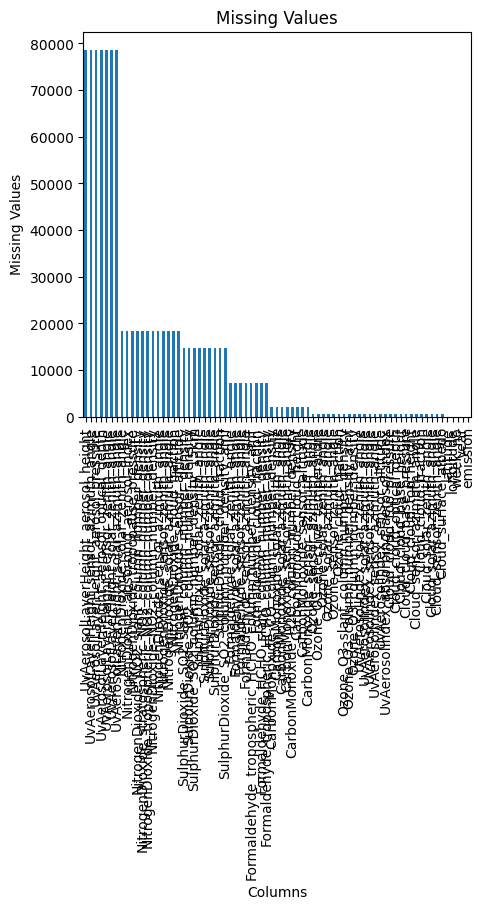

In [29]:
# Find the number of missing values in each column and visualize them using a bar chart
plt.figure(figsize=(5, 5))
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Missing Values')
plt.title('Missing Values')
plt.show()

In [30]:
# Sort the missing values in each column in descending order
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values.head(30))

UvAerosolLayerHeight_aerosol_height                        78584
UvAerosolLayerHeight_sensor_azimuth_angle                  78584
UvAerosolLayerHeight_aerosol_pressure                      78584
UvAerosolLayerHeight_aerosol_optical_depth                 78584
UvAerosolLayerHeight_sensor_zenith_angle                   78584
UvAerosolLayerHeight_solar_zenith_angle                    78584
UvAerosolLayerHeight_solar_azimuth_angle                   78584
NitrogenDioxide_solar_zenith_angle                         18320
NitrogenDioxide_absorbing_aerosol_index                    18320
NitrogenDioxide_tropopause_pressure                        18320
NitrogenDioxide_NO2_slant_column_number_density            18320
NitrogenDioxide_stratospheric_NO2_column_number_density    18320
NitrogenDioxide_tropospheric_NO2_column_number_density     18320
NitrogenDioxide_NO2_column_number_density                  18320
NitrogenDioxide_sensor_azimuth_angle                       18320
NitrogenDioxide_sensor_ze

In [31]:
# Print the number of missing values in each column, filter the columns with missing values > 50% and store them in a variable
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > (0.5 * len(df))]

print(missing_values)
# Drop the columns in df based on the variable missing_values
df.drop(missing_values.index, axis=1, inplace=True)

UvAerosolLayerHeight_aerosol_height           78584
UvAerosolLayerHeight_aerosol_pressure         78584
UvAerosolLayerHeight_aerosol_optical_depth    78584
UvAerosolLayerHeight_sensor_zenith_angle      78584
UvAerosolLayerHeight_sensor_azimuth_angle     78584
UvAerosolLayerHeight_solar_azimuth_angle      78584
UvAerosolLayerHeight_solar_zenith_angle       78584
dtype: int64


#### Performing Aggregates

In [32]:
#---------------------------------------------
# WARNING: THESE START DATES MIGHT NOT BE CORRECT
#---------------------------------------------

# Create a python function that converts week number to the start date of the week and apply it to the dataframe
def week_to_date_2019(x):
    return pd.to_datetime('2019-1-1') + pd.to_timedelta(x*7, unit='d')

def week_to_date_2020(x):
    return pd.to_datetime('2020-1-1') + pd.to_timedelta(x*7, unit='d')

def week_to_date_2021(x):
    return pd.to_datetime('2021-1-1') + pd.to_timedelta(x*7, unit='d')

# Filter the dataframe to include only 2019 data for the year column and store it into 2019
df_2019 = df[df['year'] == 2019]

# Filter the dataframe to include only 2020 data for the year column and store it into 2020
df_2020 = df[df['year'] == 2020]

# Filter the dataframe to include only 2021 data for the year column and store it into 2021
df_2021 = df[df['year'] == 2021]

# Create a new column called date and apply the week_to_date_2019 function to the week_no column for df_2019
df_2019['date'] = df_2019['week_no'].apply(week_to_date_2019)

# Create a new column called date and apply the week_to_date_2020 function to the week_no column for df_2020
df_2020['date'] = df_2020['week_no'].apply(week_to_date_2020)

# Create a new column called date and apply the week_to_date_2021 function to the week_no column for df_2021
df_2021['date'] = df_2021['week_no'].apply(week_to_date_2021)

# Merge the 3 dataframes together and store it into a dataframe based on the date column
df = pd.concat([df_2019, df_2020, df_2021], ignore_index=True)

/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/504923843.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/504923843.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/504923843.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [33]:
#---------------------------------------------
# WARNING: THIS REMOVES ALL ROWS WITH MISSING VALUES WITHOUT REPLACING THEM
#---------------------------------------------
# Perform a groupby on the date column and store it into a variable, we are grouping by the mean of the emissions
group_by_date = df.groupby('date').mean()

In [34]:
# Drop latitude, longitude, year, week_no columns
group_by_date.drop(['latitude', 'longitude', 'year', 'week_no'], axis=1, inplace=True)

# Extract the year from the date column and store it into a new column called year
group_by_date['year'] = group_by_date.index.year

# Extract the month from the date column and store it into a new column called month
group_by_date['month'] = group_by_date.index.month

# Remove the dates 2020-03-01 to 2021-01-01 from the dataframe
#group_by_date = group_by_date[~((group_by_date.index >= '2020-03-01') & (group_by_date.index <= '2021-01-01'))]

### EDA (Exploratory Data Analysis)


#### Checking for Emission by Location (Longitude and Latitude)

In [35]:
# Latitude and longitude
import plotly.express as px

fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="emission", size="emission", color_continuous_scale=px.colors.sequential.thermal, size_max=15,zoom=7, height=800, width=1000,) 
fig.update_layout(mapbox_style="open-street-map", title='Map')
fig.show()

#### Checking Emission Trend and Average 

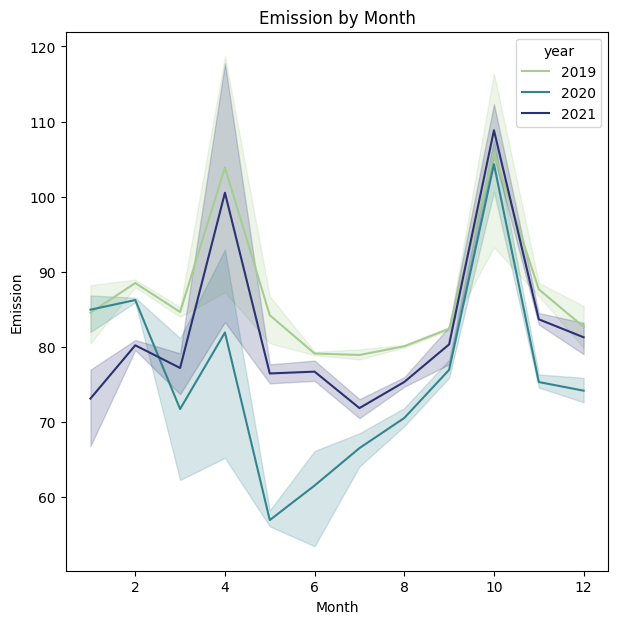

In [36]:
# Plot the emission against month, use gradient colors for the line
plt.figure(figsize=(7, 7))
sns.lineplot(x='month', y='emission', data=group_by_date, palette='crest', hue='year')
plt.xlabel('Month')
plt.ylabel('Emission')
plt.title('Emission by Month')
plt.show()

/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/527771559.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




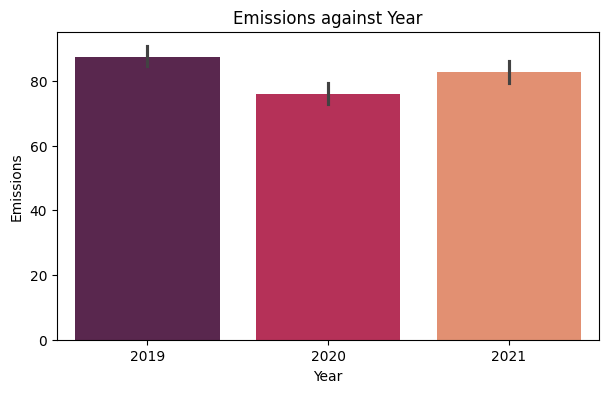

In [37]:
# Plot the total emission of each year using a bar plot
plt.figure(figsize=(7, 4))
sns.barplot(x=group_by_date['year'], y=group_by_date['emission'], palette='rocket')
plt.xlabel('Year')
plt.ylabel('Emissions')
plt.title('Emissions against Year')
plt.show()

#### Checking for Seasonality and Stationarity

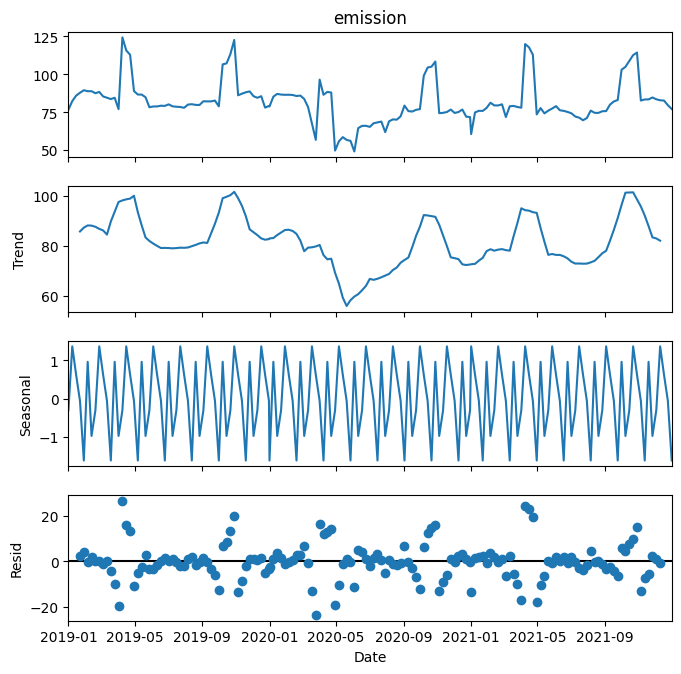

In [38]:
# Decompose data by selecting the appropiate frequency
decomp = sm.tsa.seasonal_decompose(
  group_by_date['emission'], period=7)
decomp_plot = decomp.plot()

plt.xlabel('Date')
decomp_plot .set_figheight(7)
decomp_plot .set_figwidth(7)
plt.show()

In [39]:
# Check for stationarity using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

# Create a function to check for stationarity
def check_stationarity(data):
    result = adfuller(data)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('{}: {}'.format(key, value))

# Apply the check_stationarity function to the emission column
check_stationarity(group_by_date['emission'])


ADF Statistic: -5.076376973073706
p-value: 1.5636173540917274e-05
Critical Values:
1%: -3.4724305215713156
5%: -2.8800127935315465
10%: -2.576619230892485


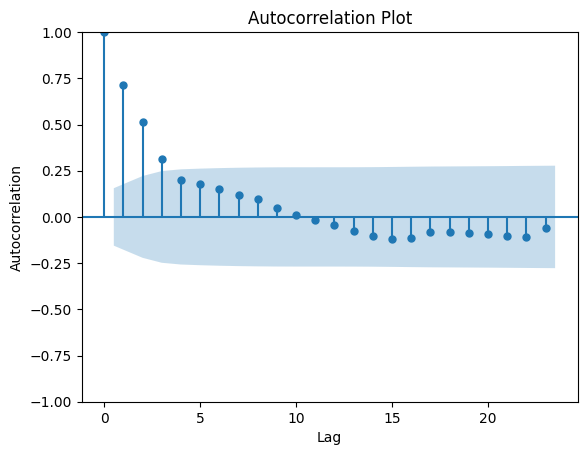

In [40]:
# Plot the autocorrelation plot for the emission column
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation plot for the emission column
plot_acf(group_by_date['emission'])
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

#### Checking Correlation of Features and Label (Emission)

/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/860472732.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




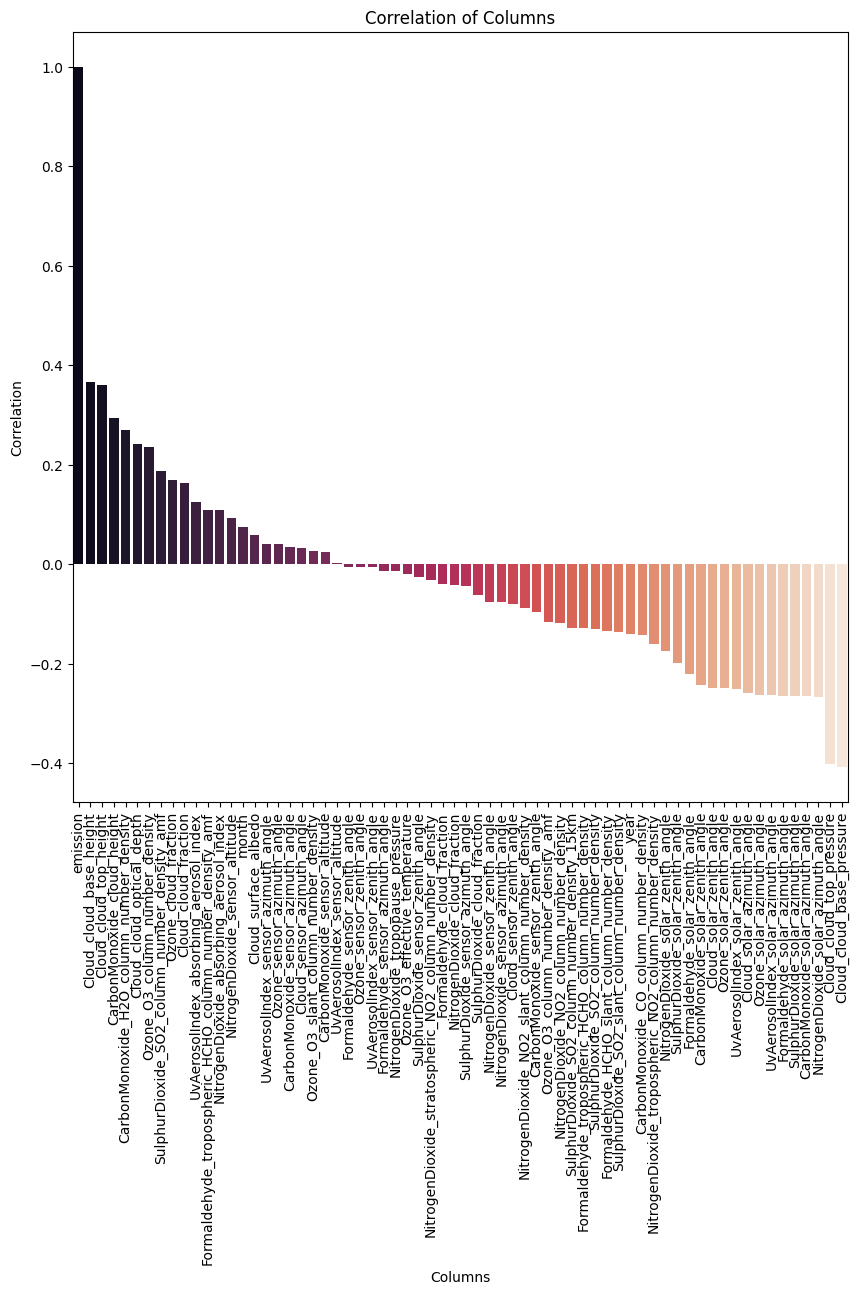

In [41]:
# Perform correlation on the dataframe, sort the values in descending order and store it into a variable
corr = group_by_date.corr()
corr = corr.sort_values('emission', ascending=False)

# Plot the emmission column in corr, use gradient colors for the bars
plt.figure(figsize=(10, 10))
sns.barplot(x=corr.index, y=corr['emission'], palette='rocket')
plt.xlabel('Columns')
plt.ylabel('Correlation')
# Rotate the xticks
plt.xticks(rotation=90)
plt.title('Correlation of Columns')
plt.show()


In [42]:
# Select the top 30 features with the highest correlation to emission
top_30 = corr['emission'].head(30)

# Filter the values from top_30 that are above 0.1 and store it into a variable
top_features = top_30[top_30 > 0.1]
top_features = top_features.reset_index()

# Rename the index column name to features  and emission to correlation
top_features.rename(columns={'index': 'features', 'emission': 'correlation'}, inplace=True)

# Remove the emission row from features
top_features.drop(0, inplace=True)
top_features.head(100)

features  correlation
1                             Cloud_cloud_base_height     0.366433
2                              Cloud_cloud_top_height     0.359630
3                         CarbonMonoxide_cloud_height     0.293825
4            CarbonMonoxide_H2O_column_number_density     0.269263
5                           Cloud_cloud_optical_depth     0.242063
6                      Ozone_O3_column_number_density     0.235452
7        SulphurDioxide_SO2_column_number_density_amf     0.187266
8                                Ozone_cloud_fraction     0.169456
9                                Cloud_cloud_fraction     0.163202
10             UvAerosolIndex_absorbing_aerosol_index     0.124120
11  Formaldehyde_tropospheric_HCHO_column_number_d...     0.109733
12            NitrogenDioxide_absorbing_aerosol_index     0.107926

#### Checking Distribution of Emission

Skewness: 0.9042056155543037
Kurtosis: 1.6416357563118584


/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/3371830688.py:15: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




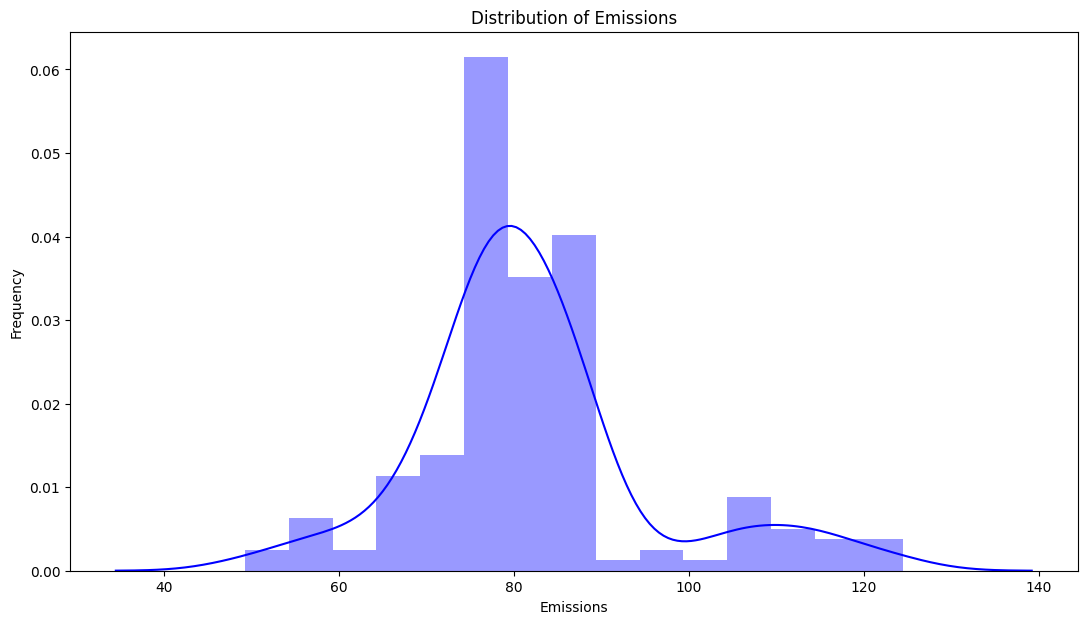

In [43]:
# Plot the distribution of the emission column
#plt.figure(figsize=(7, 7))
#sns.distplot(group_by_date['emission'])
#plt.xlabel('Emissions')
#plt.ylabel('Frequency')
#plt.title('Distribution of Emissions')
#plt.show()

# Check for skewness and kurtosis of the emission column
print('Skewness: {}'.format(group_by_date['emission'].skew()))
print('Kurtosis: {}'.format(group_by_date['emission'].kurt()))

# Plot the distribution of the emission column, use kde and bins=15, use darkgrid for the style, set the figure size to (13, 7)
plt.figure(figsize=(13, 7))
sns.distplot(group_by_date['emission'], kde=True, bins=15, color='blue')
plt.xlabel('Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of Emissions')
plt.show()


#### Checking for Outliers

/var/folders/_x/ry3jbs9j2b50yr7wpq6rgkrc0000gn/T/ipykernel_59381/1628561247.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




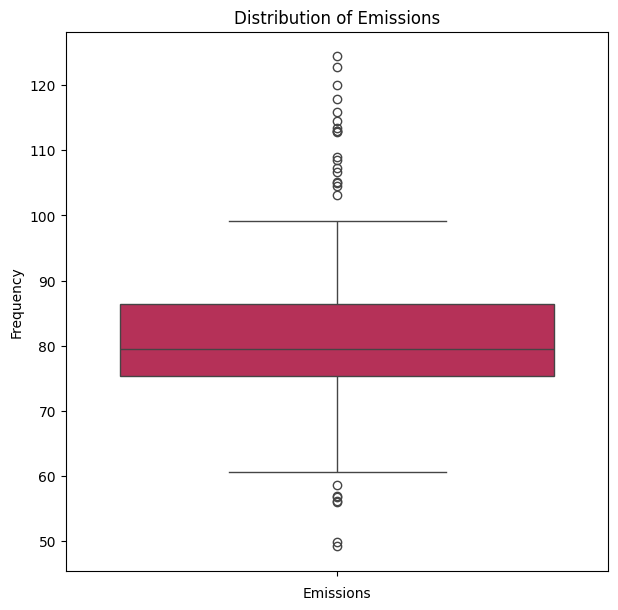

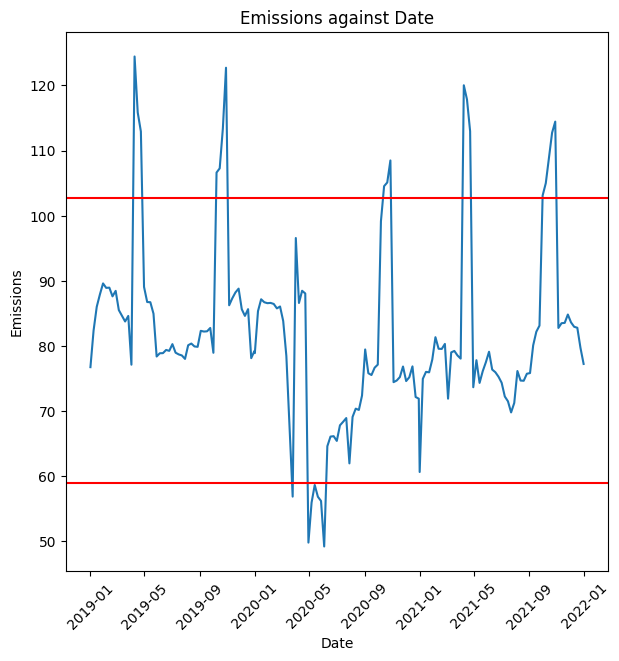

In [44]:
# Check for outliers using the interquartile range
q1 = group_by_date['emission'].quantile(0.25)
q3 = group_by_date['emission'].quantile(0.75)
iqr = q3 - q1

# Calculate the upper and lower bound values
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

emission_mean = group_by_date['emission'].mean()
emission_std = group_by_date['emission'].std()


# Plot the chart with the outliers
plt.figure(figsize=(7, 7))
sns.boxplot(group_by_date['emission'], palette='rocket')
plt.xlabel('Emissions')
plt.ylabel('Frequency')
plt.title('Distribution of Emissions')
plt.show()

# Plot the emission line plot with upper and lower bound values
plt.figure(figsize=(7, 7))
plt.plot(group_by_date['emission'])
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.title('Emissions against Date')
plt.xticks(rotation=45)
plt.axhline(y=upper_bound, color='r', linestyle='-')
plt.axhline(y=lower_bound, color='r', linestyle='-')
plt.show()


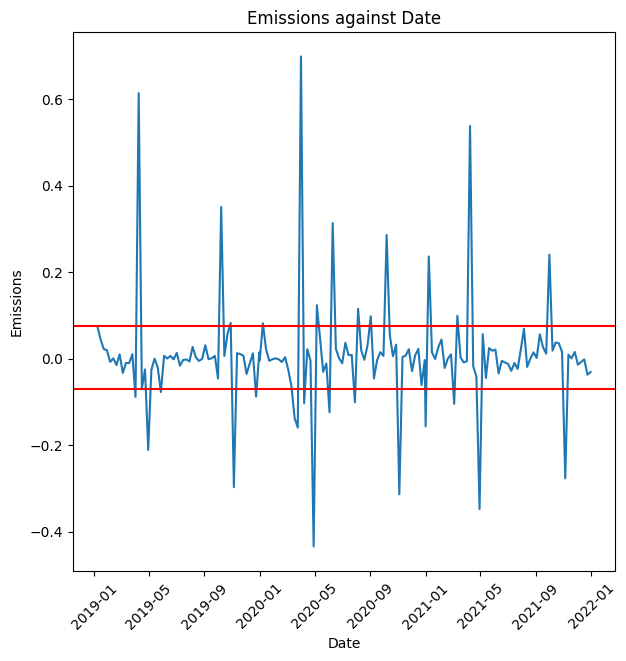

In [45]:
pct_change = group_by_date.pct_change()
# Check for outliers using the interquartile range
q1_pct_change = pct_change['emission'].quantile(0.25)
q3_pct_change = pct_change['emission'].quantile(0.75)
iqr_pct_change = q3_pct_change - q1_pct_change

# Calculate the upper and lower bound values
upper_bound_pct_change = q3_pct_change + 1.5 * iqr_pct_change
lower_bound_pct_change = q1_pct_change - 1.5 * iqr_pct_change

# Plot the emission_pct_change line plot with upper and lower bound values
plt.figure(figsize=(7, 7))
plt.plot(pct_change['emission'])
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.title('Emissions against Date')
plt.xticks(rotation=45)
plt.axhline(y=upper_bound_pct_change, color='r', linestyle='-')
plt.axhline(y=lower_bound_pct_change, color='r', linestyle='-')
plt.show()


### Feature Engineering

#### Feature Selection

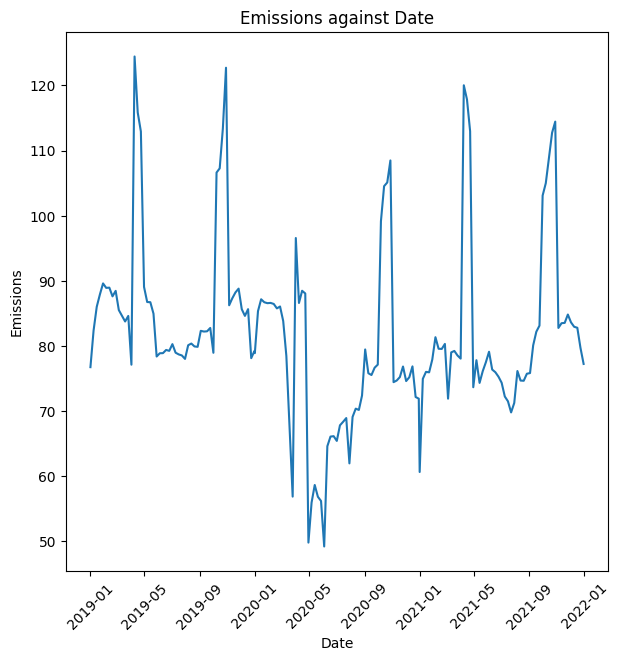

In [46]:
# Filter the columns in group_by_date based on the features column in features and include the emission column as well

#group_by_date.head()
#features_label_list = top_features['features'].to_list()
#features_label_list.append('emission')
#df2 = group_by_date[features_label_list]
#df2.head()

# Remove this later
df2 = group_by_date

# Remove the dates between 2020-03-01 and 2020-12-31 from df2 to cater for the lockdown period
#df2 = df2.loc[~((df2.index >= '2020-03-01') & (df2.index <= '2021-01-01'))]

# Plot the emission column in df2
plt.figure(figsize=(7, 7))
plt.plot(df2['emission'])
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.title('Emissions against Date')
plt.xticks(rotation=45)
plt.show()

# Export df2 to a csv file
df2.to_csv('data/df2.csv', index=True)


#### Split Data

In [47]:
# Split the dataframe into train and test set, use 80% for train and 20% for test, set the random state to 42
from sklearn.model_selection import train_test_split

X = df2.drop('emission', axis=1)
y = df2['emission']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Scale Data

In [48]:
# Scale the data using the StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)


In [49]:
# Fix the skewness of y_train using log transformation
y_train_log = np.log(y_train)

#### Remove Outliers

In [50]:
# Remove outliers using the interquartile range
from scipy import stats

#z = np.abs(stats.zscore(X_scaled_train))
#threshold = 3
#X_scaled_train = X_scaled_train[(z < 3).all(axis=1)]
#y_train = y_train[(z < 3).all(axis=1)]


### Train & Evaluate Model

#### Train and Evaluate using LightGBM

In [59]:
# Train a linear regression model on the train set using lightgbm
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression

model = lgb.LGBMRegressor()
#model = xgb.XGBRegressor()
#model = LinearRegression()
model.fit(X_scaled_train, y_train_log)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2789
[LightGBM] [Info] Number of data points in the train set: 127, number of used features: 65
[LightGBM] [Info] Start training from score 4.384086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor()

#### Evaluation

RMSE: 12.197072910562524


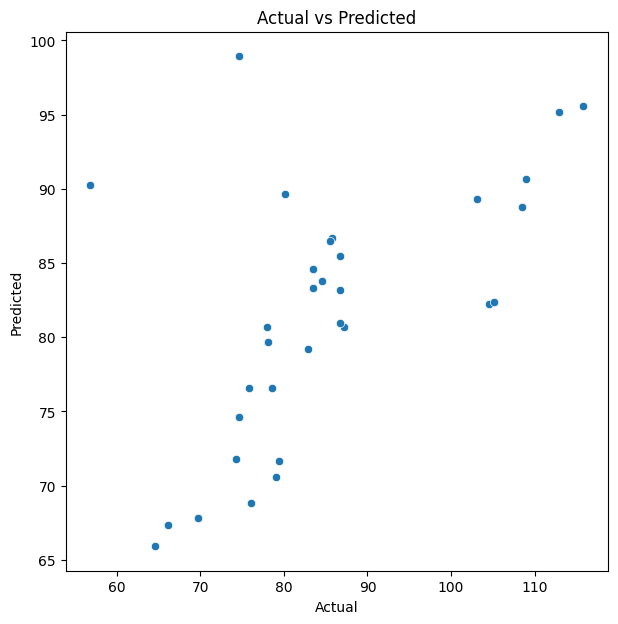

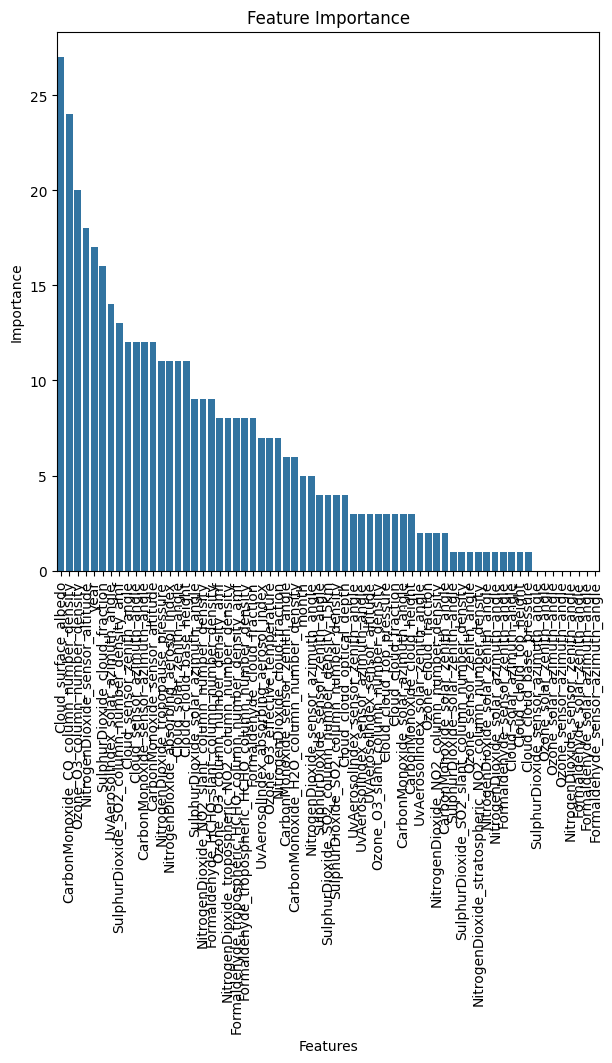

In [60]:
# Predict the emission values on the test set
y_pred = model.predict(X_scaled_test)

# Inverse transform the predicted values back to its original scale
y_pred = np.exp(y_pred)

# Calculate the rmse score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {}'.format(rmse))

# Plot the actual vs predicted values using scatterplot
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Extract the feature importance from the model and store it into a variable
feature_importance = model.feature_importances_

# Sort the feature importance in descending order and store it into a variable
feature_importance = sorted(zip(feature_importance, X.columns), reverse=True)

# Plot the feature importance using a bar plot
plt.figure(figsize=(7, 7))
sns.barplot(x=[x[1] for x in feature_importance], y=[x[0] for x in feature_importance])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()




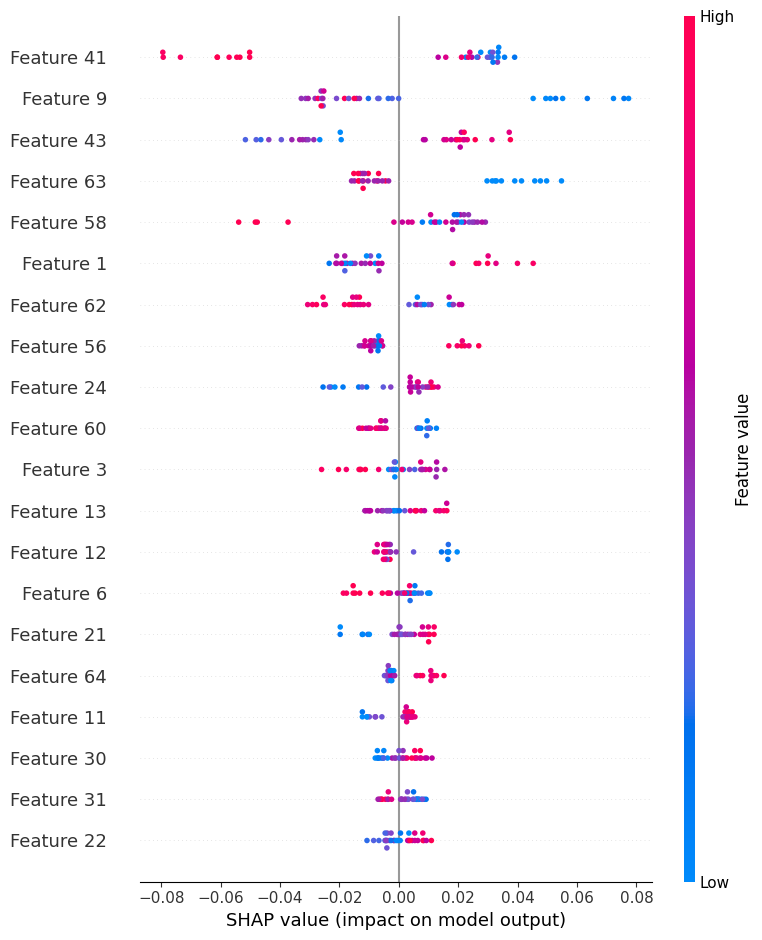

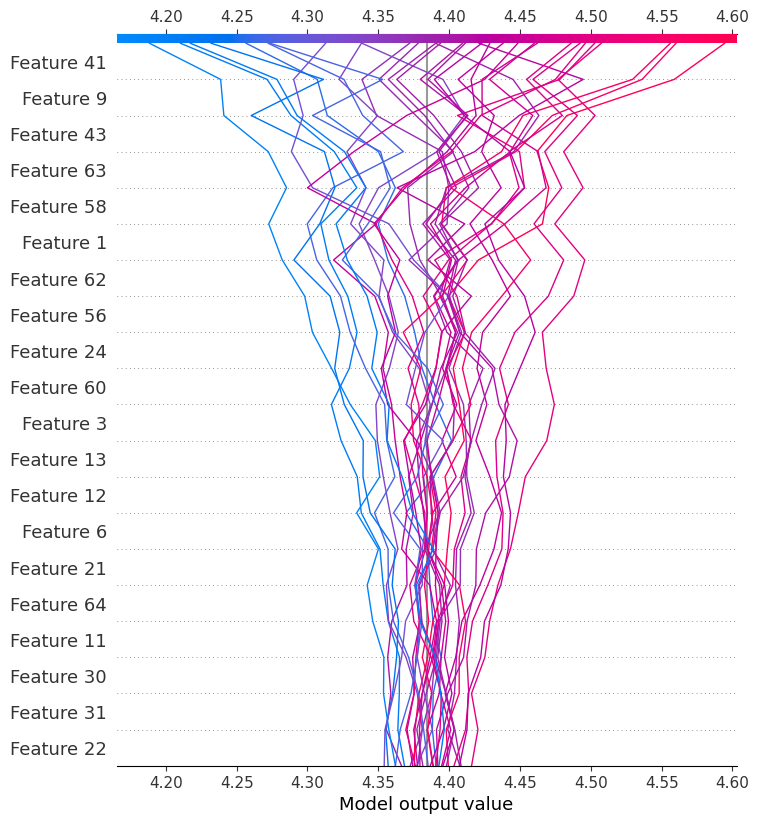

In [61]:
# Plot shap values for the model
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled_test)

shap.summary_plot(shap_values, X_scaled_test)
shap.decision_plot(explainer.expected_value, shap_values, X_scaled_test)


In [62]:
# Extract the top 5 values from shap_values and store it into a variable
top_5 = np.argsort(np.abs(shap_values[0, :]))[-5:]
top_5 = top_5[::-1]

print(top_5)

# Extract the column names from X based on the top_5 indices and store it into a variable
top_5_features = X.columns[top_5]

print(top_5_features)

[41 43 58  9 63]
Index(['UvAerosolIndex_solar_azimuth_angle', 'Ozone_O3_column_number_density',
       'Cloud_surface_albedo', 'CarbonMonoxide_CO_column_number_density',
       'year'],
      dtype='object')


In [55]:
# Export the model as a pickle file
import pickle
pickle.dump(model, open('model/model.pkl', 'wb'))